Check weak-lensing signal for particle data. Modified from Alexie's code (`calds_secretplot.py`)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

import h5py
from astropy.io import ascii
from halotools.mock_observables import return_xyz_formatted_array
from halotools.mock_observables import delta_sigma

# #---------------------------------------------------------------------------#
# #User imports
# import sys
# sys.path.append('/Users/fardila/Documents/GitHub/HSC_vs_hydro/')
# from functions import *

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## box size 

In [ ]:
# Massive black 2: Lbox = 100 h^-1 Mpc
# TNG100: Lbox = 75 h^-1 Mpc

Lbox = 75.0   # 75/h
period = np.array([Lbox,Lbox,Lbox])

# This is in Mpc/h comoving
rp_bins = np.logspace(-1.2,1.2,20) #error if using 1.5 because Lbox is 75 and not 100
print rp_bins

## particle positions

In [4]:
particle_data_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/particles/boxptl_tng100-2_099.hdf5'

In [33]:
f = h5py.File(particle_data_file, 'r')

dm_coords = np.array(f['ptldm_Coordinates'])
dm_particle_mass = np.array(f['config'].attrs['dm_ptl_mass'])

gas_coords = np.array(f['ptlgas_Coordinates'])
gas_particle_masses = np.array(f['ptlgas_Masses'])

star_coords = np.array(f['ptlstr_Coordinates'])
star_particle_masses = np.array(f['ptlstr_Masses'])

z = f['config'].attrs['snap_z']
n_downsampled_particles = f['config'].attrs['ptlgas_nmax']
f.close()

print "Redshift: ", z
print n_downsampled_particles, ' particles'


Redshift:  0.0
20000000  particles


In [15]:
max(dm_coords[:,0]) ##kpc?

74999.99887498413

In [16]:
def format_coordinates_for_halotools(coords):
    # These are in units of kpc???, put into Mpc
    x=coords[:,0]/1000.0
    y=coords[:,1]/1000.0
    z=coords[:,2]/1000.0
    
    pos = return_xyz_formatted_array(x, y, z)
    
    return pos

dmpos = format_coordinates_for_halotools(dm_coords)
gaspos = format_coordinates_for_halotools(gas_coords)
starpos = format_coordinates_for_halotools(star_coords)

In [ ]:
#check mass units
#check position units
#check number of particles for each species

### number of particles 

In [19]:
#illustris-1: 1820^3 DM particles
#illustris-2: 910^3 DM particles

n_total_particles_dm, n_total_particles_gas, n_total_particles_stars = 910**3, 910**3, 910**3

dm_downsampling_factor = n_total_particles_dm/n_downsampled_particles
gas_downsampling_factor = n_total_particles_gas/n_downsampled_particles
star_downsampling_factor = n_total_particles_stars/n_downsampled_particles

## galaxy positions 

In [26]:
# Read in the Galaxy File
tng_highres_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_stellarmaps_tng75_11.2_highres.hdf5'
f = h5py.File(tng_highres_file, 'r')
gal_coords = np.array(f['catsh_SubhaloPos'])
f.close()

galpos = format_coordinates_for_halotools(gal_coords)


## weak lensing

In [48]:
output_files_location = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/particles/'

In [74]:
r, dm_ds = delta_sigma(galpos, dmpos, dm_particle_mass, dm_downsampling_factor, rp_bins, Lbox)
dm_ds = dm_ds/1e12
dm_array = np.array(zip(r,dm_ds), dtype=[('r(Mpc)','f8'),('DS','f8')])
np.save(output_files_location+'dm_ds.npy', dm_array)
print 'dm_ds', dm_ds

r, gas_ds = delta_sigma(galpos, gaspos, gas_particle_masses, gas_downsampling_factor, rp_bins, Lbox)
gas_ds = gas_ds/1e12
gas_array = np.array(zip(r,gas_ds), dtype=[('r(Mpc)','f8'),('DS','f8')])
np.save(output_files_location+'gas_ds.npy', gas_array)
print 'gas_ds', gas_ds

r, stars_ds = delta_sigma(galpos, starpos, star_particle_masses, star_downsampling_factor, rp_bins, Lbox)
stars_ds = stars_ds/1e12
stars_array = np.array(zip(r,stars_ds), dtype=[('r(Mpc)','f8'),('DS','f8')])
np.save(output_files_location+'stars_ds.npy', stars_array)
print 'stars_ds', stars_ds


dm_ds [-0.25219283 -0.58025068 -0.69858474  0.24437308  0.87710176  1.28236368
  2.34096613  2.36505694  3.2453111   3.70314316  3.72516997  3.57583353
  2.70975197  1.75532599  1.48553747  1.14206128  0.60997531  0.68049556
  0.68773949]
gas_ds [-0.02671999 -0.00344317  0.04765049  0.07319329  0.12399887  0.21972268
  0.31417252  0.43552254  0.53032878  0.59922775  0.61309432  0.607535
  0.48817853  0.32438755  0.27780886  0.21660792  0.11882075  0.130444
  0.13147895]
stars_ds [-0.83607155 -1.54021436 -2.15961689 -0.29126165  0.94962018  0.17868208
  1.74112311  0.64497408  1.04024591  1.15039218  1.00888376  0.93708203
  0.66473285  0.37932909  0.35393234  0.25178355  0.11642791  0.13630752
  0.14118951]


# Plots 

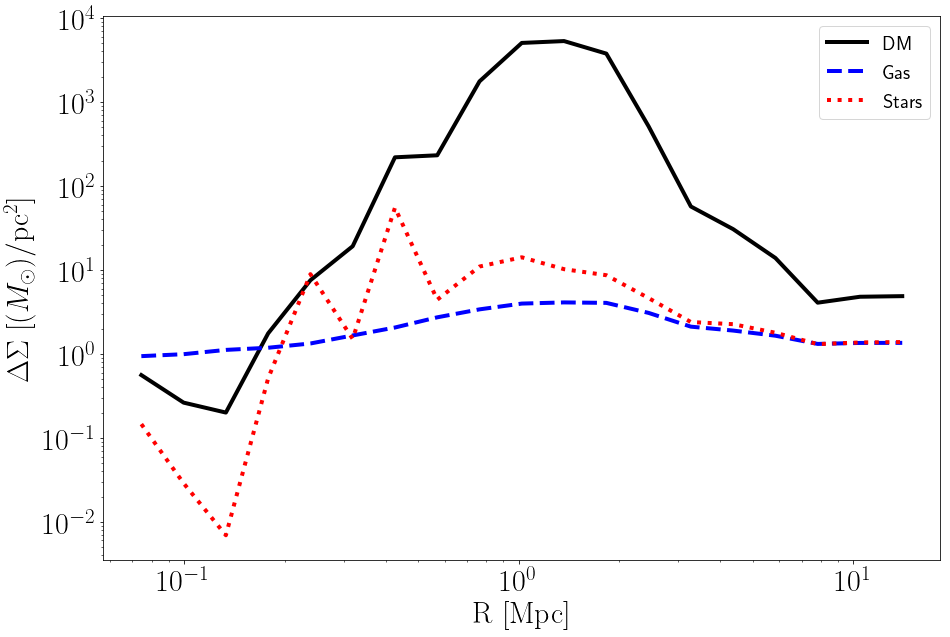

In [43]:
#plot
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot()

plt.loglog(r, 10**dm_ds, linestyle='-', linewidth=4.0, c='k', alpha=1, zorder=8, label='DM')
plt.loglog(r, 10**gas_ds, linestyle='--', linewidth=4.0, c='b', alpha=1, zorder=8, label='Gas')
plt.loglog(r, 10**stars_ds, linestyle=':', linewidth=4.0, c='r', alpha=1, zorder=8, label='Stars')
 
######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
# ax1.set_xlim(0.9, 4.5)
# ax1.set_ylim(4, 11)

ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
# ax1.text(1.8, 4.5, r'$n = $ {:01.2E} Mpc$^{{-3}}$'.format(hsc_n), size=30)

ax1.legend(fontsize=20)

#axis labels and vertical lines
ax1.set_xlabel(r'$\mathrm{R \ [Mpc]}$', fontsize=30)
ax1.set_ylabel(r'$\Delta\Sigma \ [(M_{\odot})/\mathrm{pc}^2]$', fontsize=30)
# ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
# ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

######################################################################################################################

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_Illustris_matched_n.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()